In [137]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math

In [138]:
kon = 1e5
koff = 1e-4
Target_cell_number = 5e3
D = 5e-10
cell_radius = 8e-4 # in cm
r_ab = 1.25e-6 # in cm
k2 = 4*D/(math.pi*((r_ab)**2))
t_end = 10000
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)

print(k2)

407.43665431525204


In [139]:
def model_R(t, z, Ainit, rtot1, rtot2, kon, kon1):
    k = Ainit*kon
    k1 = Ainit*kon1
    Atot = 1e16*Ainit/Target_cell_number
    A0 = Atot - z[0] - z[1] - z[2]
    Ag1 = rtot1 - z[0] - z[2]
    Ag2 = rtot2 - z[1] - z[2]
    target_effective_conc1 =(rtot1)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
    target_effective_conc2 =(rtot2)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
    k21 = target_effective_conc1*kon
    k22 = target_effective_conc2*kon1

    dA10 = (k*(Ag1)*(A0)/rtot1) - koff*z[0] - (k22*(Ag2)*z[0]/rtot2) + koff*z[2]
    dA01 = (k1*(Ag2)*(A0)/rtot2) - koff*z[1] - (k21*(Ag1)*z[1]/rtot1) + koff*z[2]
    dA11 = (k22*(Ag2)*z[0]/rtot2) + (k21*(Ag1)*z[1]/rtot1) - 2*koff*z[2]

    return [dA10, dA01, dA11]

def model_S(t, z, Ainit, rtot1, rtot2, kon, kon1):
    k = Ainit*kon
    k1 = Ainit*kon1
    Atot = 1e16*Ainit/Target_cell_number
    A0 = Atot - z[0] - z[1] - z[2]
    Ag1 = rtot1 - z[0] - z[2]
    Ag2 = rtot2 - z[1] - z[2]

    dA10 = (k*(Ag1)*(A0)/rtot1) - koff*z[0] - (k2*(Ag2)*z[0]/rtot2) + koff*z[2]
    dA01 = (k1*(Ag2)*(A0)/rtot2) - koff*z[1] - (k2*(Ag1)*z[1]/rtot1) + koff*z[2]
    dA11 = (k2*(Ag2)*z[0]/rtot2) + (k2*(Ag1)*z[1]/rtot1) - 2*koff*z[2]

    return [dA10, dA01, dA11]

In [140]:
rtot1 = 1e5
factor = 25
rtot2 = rtot1/factor
kon1 = 1e5
z0 = [0, 0, 0]
vals = np.linspace(1, 9, 50)

A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
A0s = []

for x in A0s1:
    for val in vals:
        A0s.append(x*val)

Ab_vals = np.zeros(len(A0s))
Ag1_vals = np.zeros(len(A0s))
Ag2_vals = np.zeros(len(A0s))

for i in range(len(A0s)):

    z = solve_ivp(model_R, tspan, z0, method='Radau', t_eval=t, args=(A0s[i], rtot1, rtot2, kon, kon1))

    A10 = z.y[0]
    A01 = z.y[1]
    A11 = z.y[2]
    A10st = A10[-1]
    A01st = A01[-1]
    A11st = A11[-1]
    
    Ab = 1 - (((rtot1 - A10st - A11st) + (rtot2 - A01st - A11st))/(rtot1 + rtot2))
    Ag1 = (rtot1 - A10st - A11st)/rtot1
    Ag2 = (rtot2 - A01st - A11st)/rtot2

    Ab_vals[i] = Ab
    Ag1_vals[i] = Ag1
    Ag2_vals[i] = Ag2



In [141]:
rtot1 = 1e5
Ainit = 1e-5
print(1e16*Ainit/(Target_cell_number*rtot1))


200.00000000000003


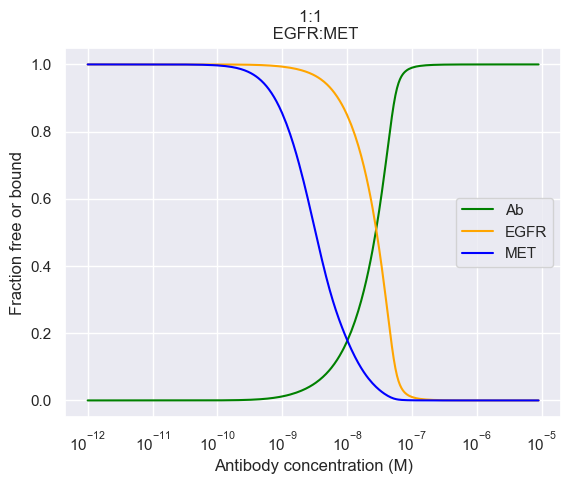

In [142]:
sns.set_theme()

plt.plot(A0s, Ab_vals, 'green', label = 'Ab')
plt.plot(A0s, Ag1_vals, 'orange', label = 'EGFR')
plt.plot(A0s, Ag2_vals, 'blue', label = 'MET')
plt.title('1:1 \n EGFR:MET')
plt.xscale('log')
plt.xlabel('Antibody concentration (M)')
plt.ylabel('Fraction free or bound')
plt.legend(loc='best')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/ModelR_egfr_met_1:1.png')

In [143]:
kon1s = [1e5, 5e5, 1e6, 5e6]
rtot1 = 1e4
factor = 100
rtot2 = rtot1/factor
arrays = []

for val in kon1s:
    kon1 = val
    met_vals = np.zeros_like(A0s)
    for i in range(len(A0s)):
        
        z = solve_ivp(model_S, tspan, z0, method='Radau', t_eval=t, args=(A0s[i], rtot1, rtot2, kon, kon1))

        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10st = A10[-1]
        A01st = A01[-1]
        A11st = A11[-1]
    
        Ab = 1 - (((rtot1 - A10st - A11st) + (rtot2 - A01st - A11st))/(rtot1 + rtot2))
        Ag1 = (rtot1 - A10st - A11st)/rtot1
        Ag2 = (rtot2 - A01st - A11st)/rtot2

        met_vals[i] = Ag2
    
    arrays.append(met_vals)

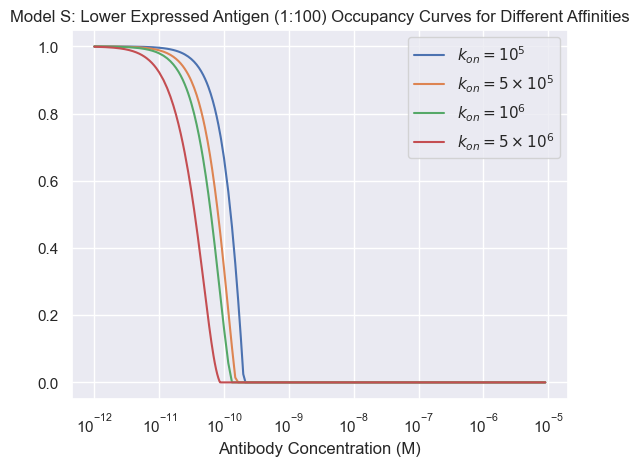

In [144]:
labels = [r'$k_{on}=10^5$', r'$k_{on}=5 \times 10^5$', r'$k_{on}=10^6$', r'$k_{on}=5 \times 10^6$']

for i in range(len(arrays)):
    plt.plot(A0s, arrays[i], label = labels[i])

plt.legend(loc='best')
plt.xlabel('Antibody Concentration (M)')
plt.title('Model S: Lower Expressed Antigen (1:100) Occupancy Curves for Different Affinities')
plt.xscale('log')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/ModelS_lower_expressed_antigen_curves_for_diff_affinities_rtot=10^3.png')

/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_950/725520621.py:10: RuntimeWarning: overflow encountered in exp
  return (np.exp(2*(beta-1)*t)-1)/(np.exp(2*(beta-1)*t)-(1/beta))
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_950/725520621.py:10: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(2*(beta-1)*t)-1)/(np.exp(2*(beta-1)*t)-(1/beta))


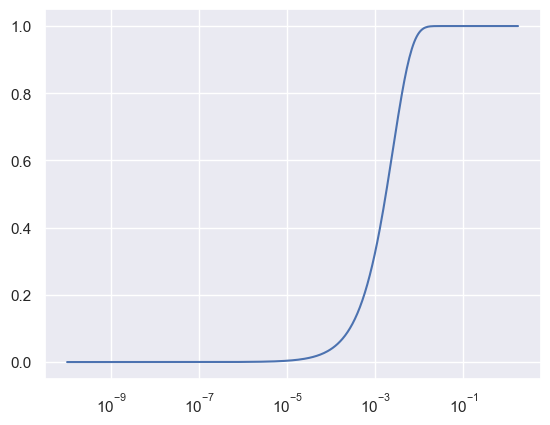

In [145]:
rtot = 1e5
Ainit = 1e-5
Atot = 1e16*Ainit/Target_cell_number
beta = Atot/rtot
epsilon = koff/k2
K1 = kon*Ainit/koff
K2 = k2/koff

def express(t):
    return (np.exp(2*(beta-1)*t)-1)/(np.exp(2*(beta-1)*t)-(1/beta))


plt.semilogx(t, express(t))
plt.show()